## Importando e Carregando Dados

In [84]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from pandas.plotting import scatter_matrix

# Carregando o dataset .arff
data = arff.loadarff('../data/car.arff')
df = pd.DataFrame(data[0])  # Convertendo para DataFrame

# Remover o prefixo b' das strings
df = df.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Exibindo as primeiras linhas do DataFrame
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Análise Inicial

In [85]:
# Verificando as informações do DataFrame
print("\nInformações do DataFrame:\n")
df.info()

print("\n")

# Resumo estatístico
df_detalhes = df.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Informações do DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB



Estatísticas do DataFrame:


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


## Pré-Processamento

### Eliminação de Atributos Irrelevantes

Felizmente o dataset não possui atributos irrelevantes, mas um exemplo de como poderiamos tratá-lo caso houvese seria: 

```python
# remove as colunas user_id e original_city
df = df.drop(columns=['user_id','original_city'])

# imprime o dataframe
display(df.head(n=10))
```

### Tratamento de Atributos com Valores Ausentes

Felizmente não há campos nulos em nosso dataset.

In [44]:
# índices das linhas que contém valores NaN
idxRowNan = pd.isnull(df).any(axis=1).to_numpy().nonzero()

# imprime apenas as linhas com valoes ausentes
display(df.iloc[idxRowNan])

,buying,maint,doors,persons,lug_boot,safety,class


In [45]:
def trataFaltantes(df):
    '''
    Normalmente substituiria os valores faltantes pela média dos outros valores do mesmo atributo de amostras que 
    fosse da mesma classe, mas como como os seus dados dessa base são categóricos, será substituido os valores 
    faltantes pela moda dos outros valores do mesmo atributo de amostras que sejam da mesma classe.
    '''
    
    # Cria um dicionário para armazenar as modas de cada classe para cada coluna
    modas = {}
    
    # Para cada coluna, calcula a moda de cada classe
    for column in df.columns:
        modas[column] = df.groupby('class')[column].agg(lambda x: x.mode()[0])

    # Verifica se há valores nulos em cada coluna e substitui
    for column in df.columns:
        if df[column].isnull().any():
            # Substitui os valores nulos pela moda correspondente à classe
            df[column].fillna(modas[column][df['class']], inplace=True)

    return df

# Supondo que você tivesse valores nulos em meu DataFrame, chamariamos a função
df = trataFaltantes(df)

# Para verificar quais linhas continham valores nulos antes da substituição, executariamos:
idxRowNan = df[df.isnull().any(axis=1)].index
print('\nAmostras que tinham valores faltantes:')
display(df.iloc[idxRowNan])


Amostras que tinham valores faltantes:


,buying,maint,doors,persons,lug_boot,safety,class


### Tratamento de Dados Inconsistentes ou Redundantes

Felizmente não há valores redundantes ou inconsistentes em nosso dataset.

In [47]:
def delDuplicatas(df):
    '''
    Para cada grupo de amostras duplicadas, mantém uma e apaga as demais.
    '''
    df = df.drop_duplicates(keep='first')
    return df

# Detectar duplicatas
df_duplicates = df[df.duplicated(keep=False)]

# Se houver valores redundantes, imprima
if len(df_duplicates) > 0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')

# Remover duplicatas
df = delDuplicatas(df)
print("\nDataFrame após remoção de duplicatas:")
display(df)

Não existem valores duplicados

DataFrame após remoção de duplicatas:


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [48]:
# Para detectar inconsistências
def delInconsistencias(df):
    '''
    Remove todas as amostras inconsistentes da base de dados.
    '''
    df = df.drop_duplicates(subset=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], keep=False)
    return df

# Obtém as amostras onde os valores dos atributos estão duplicados
df_duplicates_inconsistentes = df[df.duplicated(subset=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], keep=False)]

# Se houver inconsistências, imprima
if len(df_duplicates_inconsistentes) > 0:
    print('\nAmostras inconsistentes:')
    display(df_duplicates_inconsistentes)
else:
    print('Não existem amostras inconsistentes')

# Remover inconsistências
df = delInconsistencias(df)
print("\nDataFrame após remoção de inconsistências:")
display(df)

Não existem amostras inconsistentes

DataFrame após remoção de inconsistências:


,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [49]:
# Vamos revisar as principais estatísticas da base de dados
df_detalhes = df.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Estatísticas do DataFrame:


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


### Normalização dos Atributos

A normalização é útil quando você tem atributos numéricos contínuos que podem variar amplamente. Essa técnica é utilizada para trazer esses dados para uma escala semelhante, mas como estamos lidando principalmente com atributos categóricos, a representação binária (0 e 1) faz mais sentido. Essa abordagem captura a presença ou ausência de características de forma clara e é apropriada para a análise e a modelagem.

Mesmo que tenhamos atributos como "número de portas" ou "número de passageiros", representá-los como categorias pode ser mais adequado no contexto de nosso dataset, especialmente por eles não serem contínuos.

Por isso utilizaremos o **one-hot encoding**, uma técnica aplicada a dados categóricos para transformar cada categoria em uma nova coluna binária, onde ``1`` indica a presença da categoria e ``0`` a ausência.

In [86]:
# Aplicando one-hot encoding
df_encoded = pd.get_dummies(df, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], drop_first=True)

# Convertendo valores booleanos para inteiros
numeric_columns = df_encoded.select_dtypes(include=[bool]).columns  # Seleciona colunas booleanas
df_encoded[numeric_columns] = df_encoded[numeric_columns].astype(int)  # Converte para inteiros

print(df_encoded.head())


   class  buying_low  buying_med  buying_vhigh  maint_low  maint_med  \
0  unacc           0           0             1          0          0   
1  unacc           0           0             1          0          0   
2  unacc           0           0             1          0          0   
3  unacc           0           0             1          0          0   
4  unacc           0           0             1          0          0   

   maint_vhigh  doors_3  doors_4  doors_5more  persons_4  persons_more  \
0            1        0        0            0          0             0   
1            1        0        0            0          0             0   
2            1        0        0            0          0             0   
3            1        0        0            0          0             0   
4            1        0        0            0          0             0   

   lug_boot_med  lug_boot_small  safety_low  safety_med  
0             0               1           1           0  
1     

Em outro contexto, se fosse necessário normalizar atributos em valores numéricos. poderiamos por exemplo o seguinte script:

```python
def normalizar(X):
    m, n = X.shape  # m = qtde de objetos e n = qtde de atributos por objeto
    X_norm = np.zeros((m, n))  # inicializa X_norm com zeros
    mu = np.mean(X, axis=0)  # calcula a média
    sigma = np.std(X, axis=0, ddof=1)  # calcula o desvio padrão

    for i in range(m):
        X_norm[i, :] = (X[i, :] - mu) / sigma

    return X_norm, mu, sigma

# Identificando colunas numéricas
numeric_columns = df_encoded.select_dtypes(include=[np.number]).columns.tolist()  # Seleciona colunas numéricas
X = df_encoded[numeric_columns].values  # Seleciona os valores para normalização

# Chama a função para normalizar X
X_norm, mu, sigma = normalizar(X)

# Atualiza o DataFrame com os valores normalizados
df_encoded[numeric_columns] = X_norm
```

In [56]:
# Verificando as informações do DataFrame
print("\nInformações do DataFrame:\n")
df.info()

print("\n")

# Resumo estatístico
df_detalhes = df.describe(include='all')
print("\nEstatísticas do DataFrame:")
display(df_detalhes)


Informações do DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB



Estatísticas do DataFrame:


,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


### Detecção de *Outliers*

Se algum atributo tiver uma proporção extremamente desequilibrada, pode ser um indicativo de outliers.

Por exemplo, se um atributo tem 90% de 0s e 10% de 1s, e você espera um balanceamento mais próximo de 50/50, isso pode ser considerado anômalo.

In [87]:
# Verificando a distribuição de valores 0 e 1
for column in df_encoded.columns:
    print(f"{column}:\n{df_encoded[column].value_counts(normalize=True)}\n")

class:
class
unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: proportion, dtype: float64

buying_low:
buying_low
0    0.75
1    0.25
Name: proportion, dtype: float64

buying_med:
buying_med
0    0.75
1    0.25
Name: proportion, dtype: float64

buying_vhigh:
buying_vhigh
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_low:
maint_low
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_med:
maint_med
0    0.75
1    0.25
Name: proportion, dtype: float64

maint_vhigh:
maint_vhigh
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_3:
doors_3
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_4:
doors_4
0    0.75
1    0.25
Name: proportion, dtype: float64

doors_5more:
doors_5more
0    0.75
1    0.25
Name: proportion, dtype: float64

persons_4:
persons_4
0    0.666667
1    0.333333
Name: proportion, dtype: float64

persons_more:
persons_more
0    0.666667
1    0.333333
Name: proportion, dtype: float64

lug_boot_med:
lug_boot_m

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

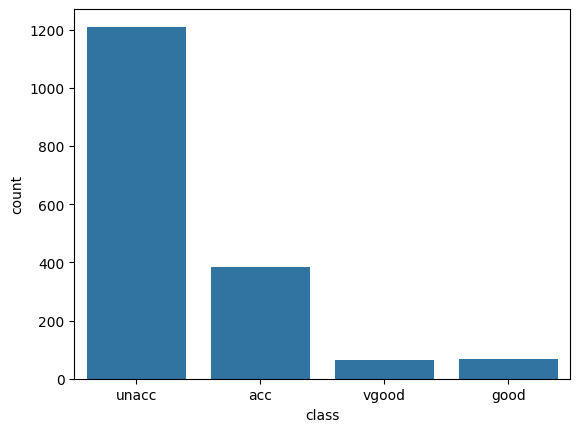

In [88]:
# Distribuição das classes
display(df['class'].value_counts())

# cria um gráfico de barras com a frequência de cada classe
sns.countplot(x="class", data=df)

# mostra o gráfico
plt.show()

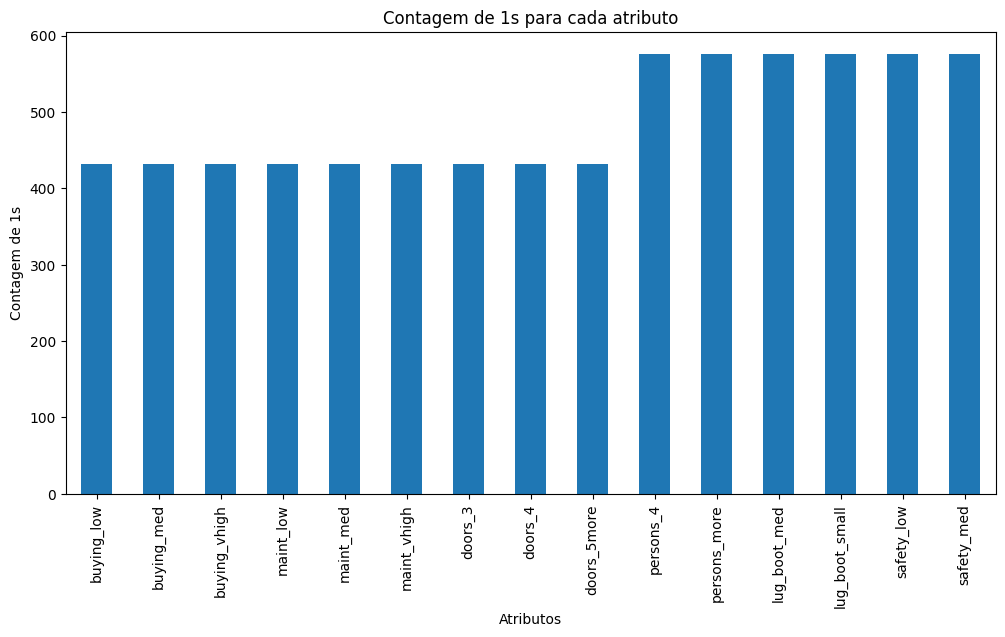

In [89]:
# Visualização em gráfico da distribuição
df_encoded.drop(columns=['class']).sum().plot(kind='bar', figsize=(12, 6))
plt.title('Contagem de 1s para cada atributo')
plt.xlabel('Atributos')
plt.ylabel('Contagem de 1s')
plt.show()

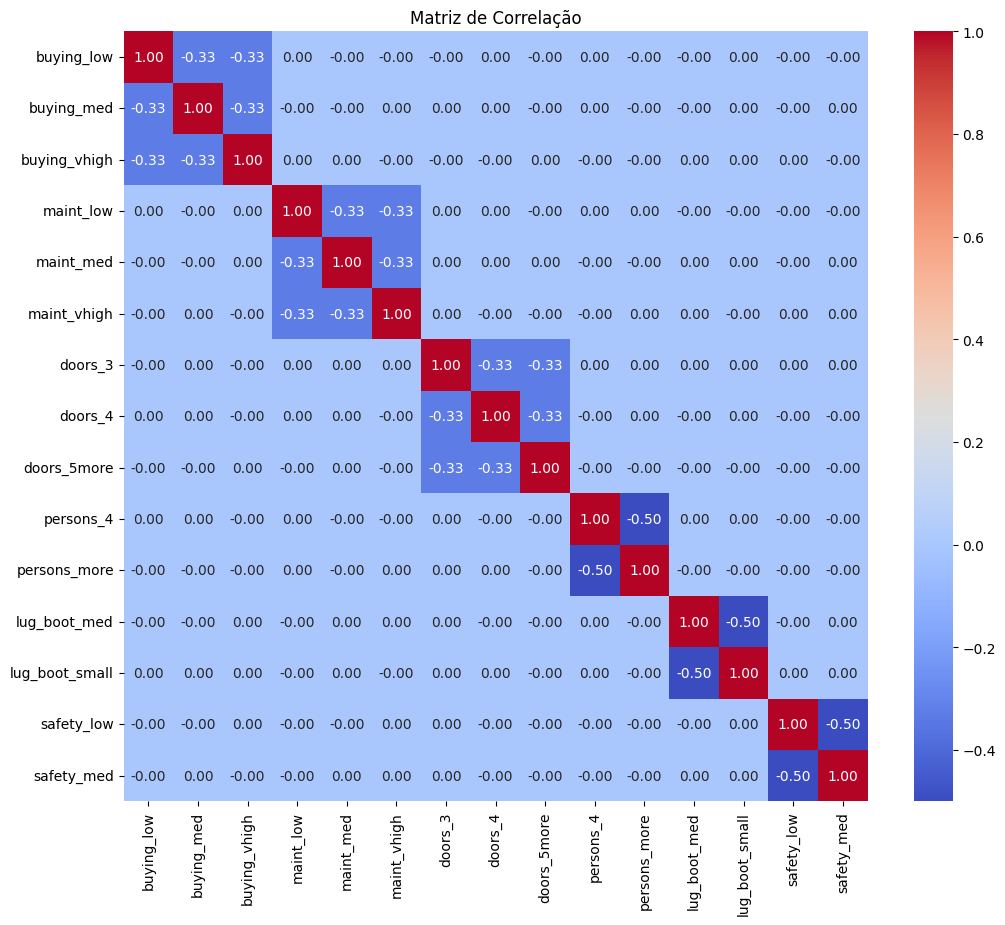

In [90]:
# Remover a coluna de classes
df_numeric = df_encoded.drop(columns=['class'])

# Calcular a matriz de correlação
correlation_matrix = df_numeric.corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


Importância dos Atributos:

1. Atributo safety_low: 0.20488844754379906
2. Atributo persons_4: 0.13005472960241216
3. Atributo persons_more: 0.11199808456896679
4. Atributo lug_boot_small: 0.07106811657476468
5. Atributo safety_med: 0.06894071242101656
6. Atributo buying_low: 0.06563268918822641
7. Atributo maint_low: 0.05480890688077081
8. Atributo buying_med: 0.050726466265998145
9. Atributo maint_med: 0.04862986004143428
10. Atributo maint_vhigh: 0.044169289089117325
11. Atributo buying_vhigh: 0.03421342988024567
12. Atributo lug_boot_med: 0.03335836333336932
13. Atributo doors_4: 0.028885163120449253
14. Atributo doors_5more: 0.027511994336383887
15. Atributo doors_3: 0.025113747153045863

***



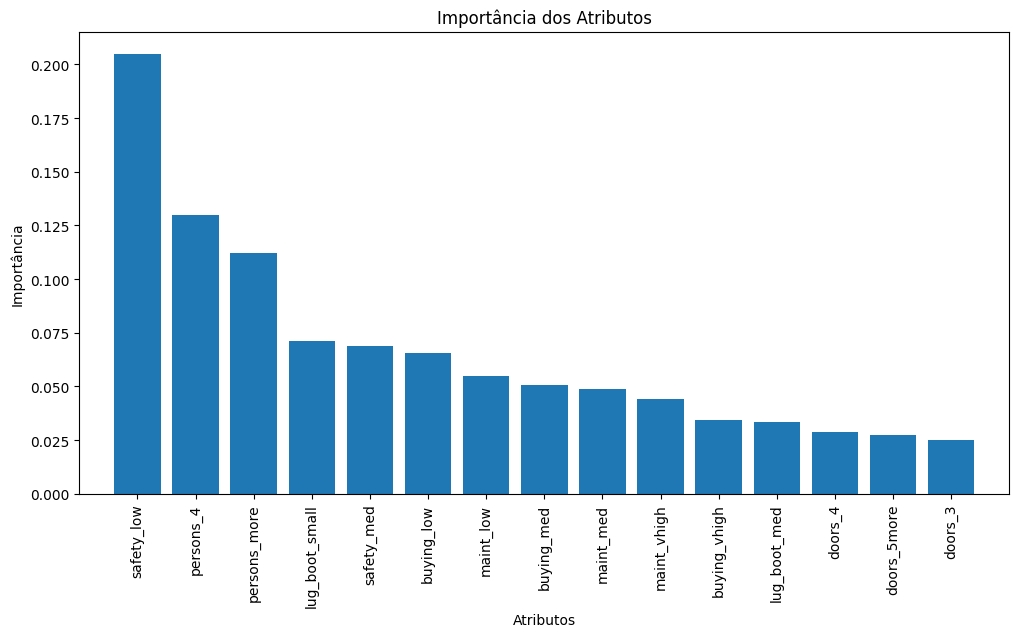

In [91]:
# Define a importância dos atributos
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

model = RandomForestClassifier()
model.fit(X, y)

# Ordena as importâncias dos atributos
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nImportância dos Atributos:\n")

# Imprime a importância dos atributos
for f in range(X.shape[1]):
    print(f"{f + 1}. Atributo {X.columns[indices[f]]}: {importances[indices[f]]}")

print("\n***\n")

# Configura o gráfico
plt.figure(figsize=(12, 6))
plt.title("Importância dos Atributos")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)  # Rótulos dos atributos
plt.xlim([-1, X.shape[1]])
plt.xlabel("Atributos")
plt.ylabel("Importância")
plt.show()



#### Analise da Proporções

1. **Classe class:**

A distribuição mostra um desbalanceamento significativo, com 70% dos dados pertencendo à classe unacc. As classes acc, good e vgood representam apenas 22%, 4% e 4%, respectivamente. Isso sugere que a classe unacc é muito mais comum, o que pode impactar a capacidade do modelo de prever as classes menos frequentes.

2. **Atributos de Compra (buying_*) e Manutenção (maint_*):**

Todos esses atributos agora apresentam uma proporção de 75% para a categoria 0 e 25% para a categoria 1. Isso indica que a maioria dos registros possui as características "baixa" ou "média" nas compras e manutenção, tornando esses atributos menos informativos em termos de variabilidade.

3. **Atributos de Portas e Pessoas (doors_*, persons_*):**

A proporção dos atributos de portas também mostra uma predominância de 75% para a categoria 0. Os atributos de pessoas têm uma leve diferença, mas ainda mostram uma distribuição que pode ser considerada desbalanceada. Isso sugere que as classes de portas e de pessoas podem não estar contribuindo muito para a distinção entre as classes.

4. **Atributos de Carga e Segurança (lug_boot_*, safety_*):**

As proporções aqui são semelhantes às dos atributos de pessoas, com 66,67% para a categoria 0 e 33,33% para a categoria 1. Isso sugere que há um pouco mais de variabilidade, mas ainda assim, a maioria dos registros está em uma única categoria.

#### Conclusão

O desbalanceamento nas classes é um problema significativo, com 70% dos dados pertencendo à classe unacc, enquanto as classes acc, good e vgood representam apenas 22%, 4% e 4%, respectivamente. Para lidar com isso, técnicas como over-sampling da classe minoritária ou under-sampling da classe majoritária podem ser úteis, assim como algoritmos que se adaptam bem a desbalanceamentos, como Random Forest ou Gradient Boosting. Além disso, a alta proporção de 0s nos atributos de compra, manutenção, portas e segurança sugere que muitos deles podem ser redundantes ou não contribuem significativamente para a predição. Uma análise de correlação e a avaliação da importância dos atributos através de modelos de árvore de decisão podem ajudar a identificar quais atributos devem ser mantidos ou descartados. Por fim, uma revisão do conjunto de dados original pode ser necessária para incluir mais dados ou atributos que forneçam maior variabilidade, contribuindo assim para otimizar o modelo e melhorar a acurácia das previsões.

Como iremos utilizar todos os campos de atributos ao receber os dados da aplicação, estes não serão removidos ou modificados apesar de notável irrelevância em alguns. Porém iremos mitigar a discrepância entre as classes, facilitando no aprendizado da máquina.

In [103]:
# Oversampling

# Separando as classes
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

# Aplicando SMOTE para aumentar a classe minoritária
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Mostra a nova distribuição das classes
print(y_resampled.value_counts())

class
unacc    1210
acc      1210
vgood    1210
good     1210
Name: count, dtype: int64


In [104]:
# Undersampling

# Aplicando RandomUnderSampler para reduzir a classe majoritária
undersample = RandomUnderSampler(random_state=42)
X_under, y_under = undersample.fit_resample(X, y)

# Mostra a nova distribuição das classes
print(y_under.value_counts())

class
acc      65
good     65
unacc    65
vgood    65
Name: count, dtype: int64


In [124]:
# Remoção de Outliers

# Exemplo de remoção de outliers com base em um limite
threshold = 0.8 * len(df_encoded)  # Por exemplo, 80% dos dados

# Seleciona apenas as colunas numéricas para a soma
numeric_columns = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

# Cria uma série booleana indicando quais colunas têm soma menor ou igual ao threshold
valid_columns = (df_encoded[numeric_columns].sum() <= threshold)

# Filtra o DataFrame para manter apenas as colunas válidas
df_cleaned = df_encoded.loc[:, valid_columns[valid_columns].index]

# Mostra a forma da nova base de dados
print(df_cleaned.shape)


(1728, 15)


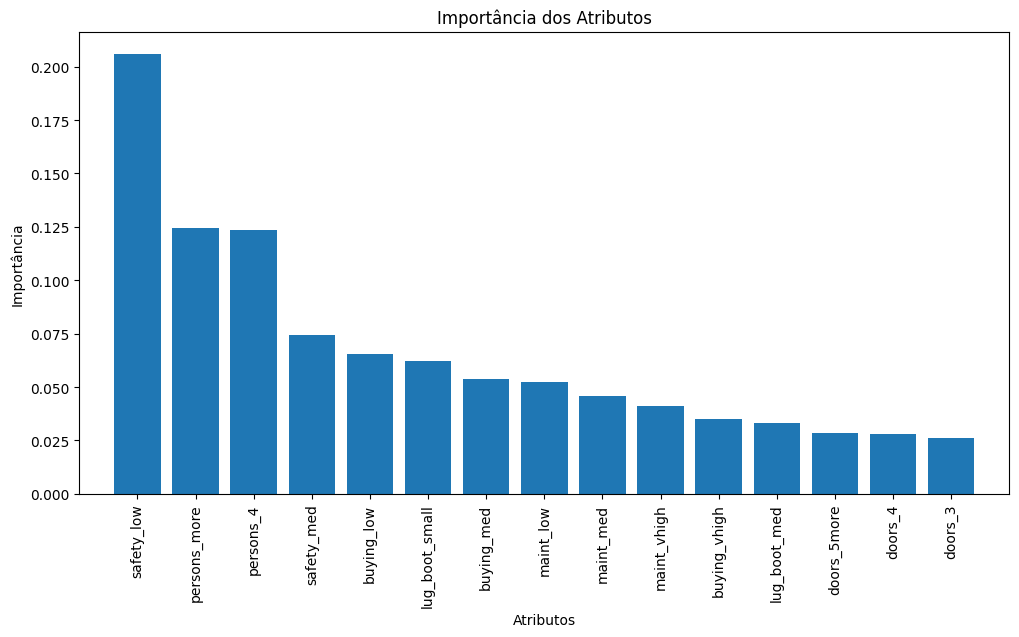

In [125]:
# Visualizando Novamente a Importâncias dos Atributos

X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importância dos Atributos")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel("Atributos")
plt.ylabel("Importância")
plt.show()

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

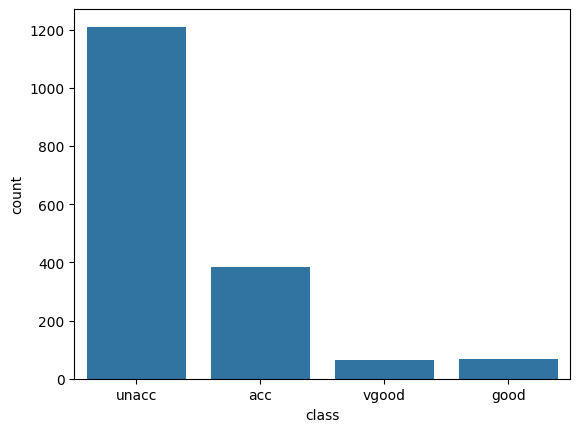

In [126]:
# Visualizando novamente a distribuição das classes

display(df['class'].value_counts())

# cria um gráfico de barras com a frequência de cada classe
sns.countplot(x="class", data=df)

# mostra o gráfico
plt.show()

> [!NOTE]
> As alterações não parecem ter surtido muito efeito no fim.

## Visualização de Dados

### Histogramas

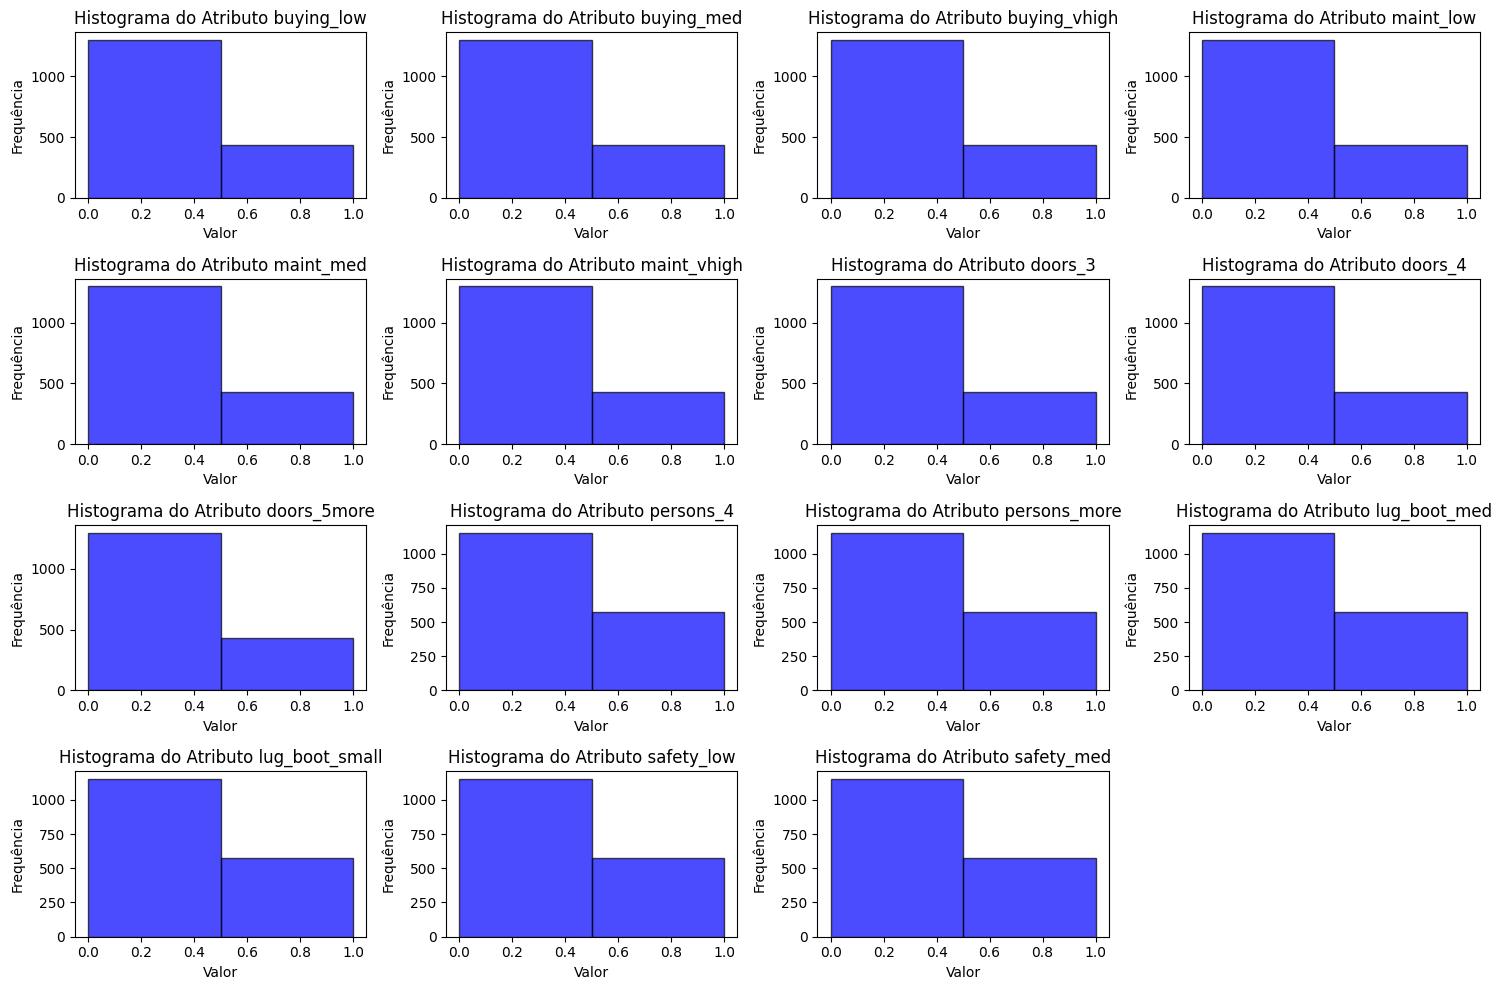

In [128]:
# Selecionando os atributos para visualização
attributes = ['buying_low', 'buying_med', 'buying_vhigh', 
              'maint_low', 'maint_med', 'maint_vhigh', 
              'doors_3', 'doors_4', 'doors_5more', 
              'persons_4', 'persons_more', 
              'lug_boot_med', 'lug_boot_small', 
              'safety_low', 'safety_med']

# Configurando o tamanho da figura
plt.figure(figsize=(15, 10))

# Loop para criar histogramas para cada atributo
for i, attr in enumerate(attributes, start=1):
    plt.subplot(4, 4, i)  # Organiza os subgráficos em uma grade
    plt.hist(df_encoded[attr], bins=2, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Histograma do Atributo {attr}')
    plt.xlabel('Valor')
    plt.ylabel('Frequência')

plt.tight_layout()  # Ajusta os subgráficos para evitar sobreposição
plt.show()

### Matriz de Dispersão

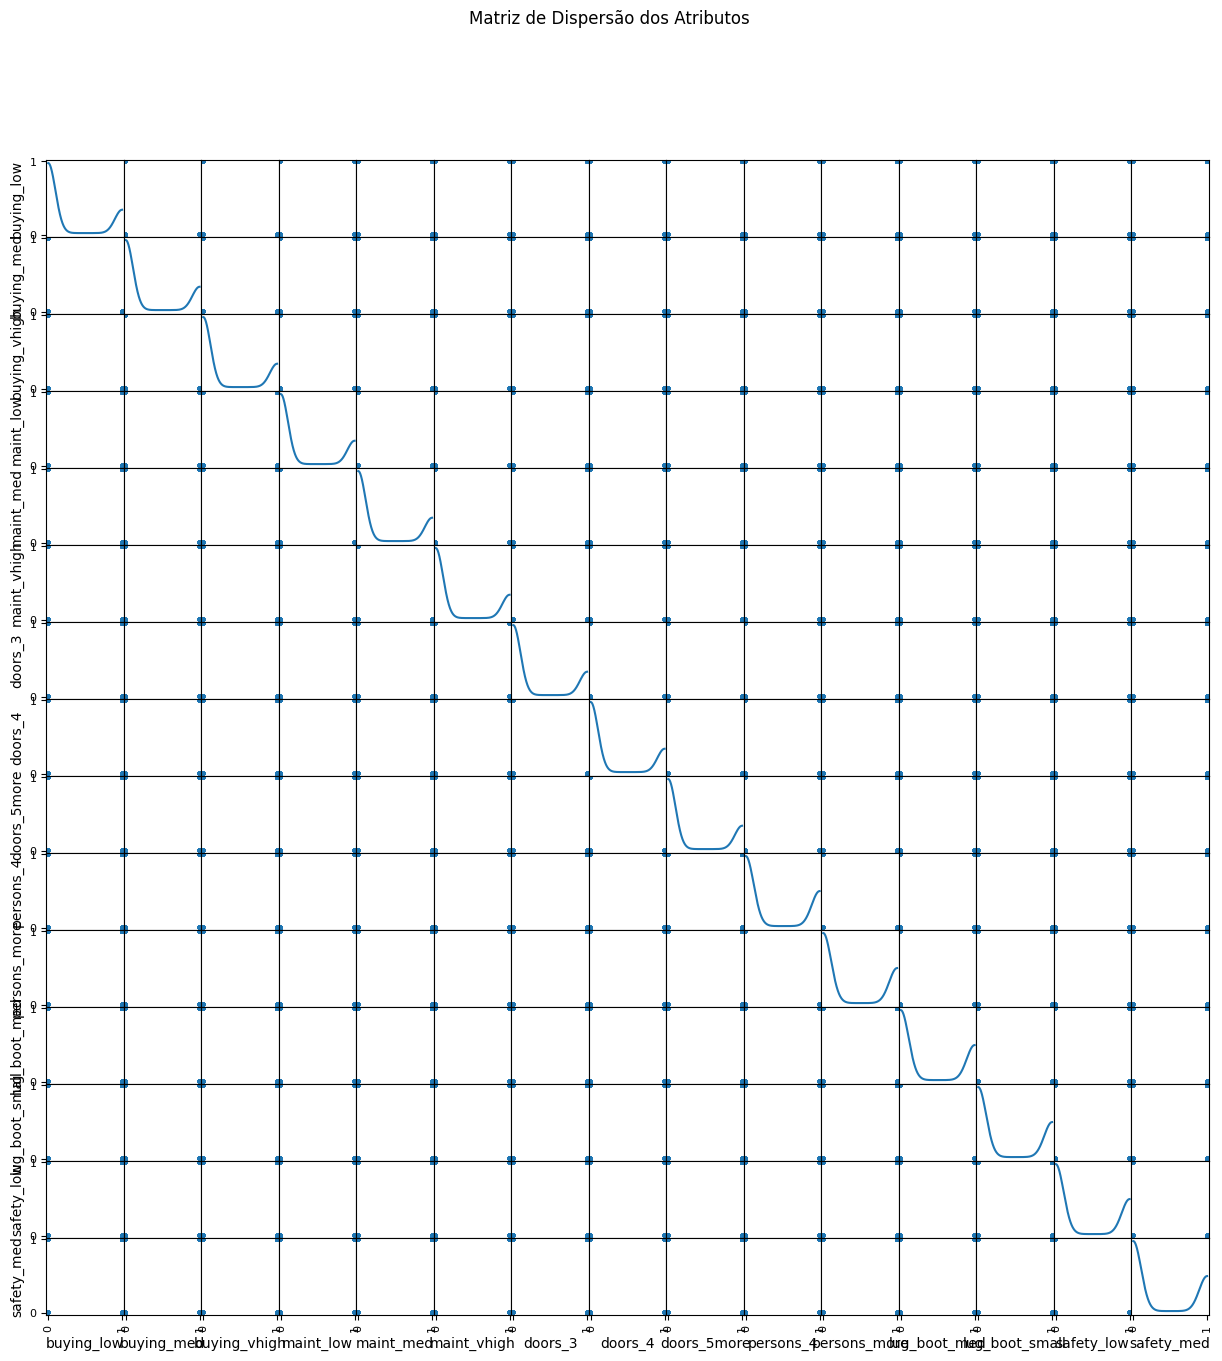

In [130]:
# Selecionando os atributos para a matriz de dispersão
attributes = ['buying_low', 'buying_med', 'buying_vhigh', 
              'maint_low', 'maint_med', 'maint_vhigh', 
              'doors_3', 'doors_4', 'doors_5more', 
              'persons_4', 'persons_more', 
              'lug_boot_med', 'lug_boot_small', 
              'safety_low', 'safety_med']

# Criando a matriz de dispersão
scatter_matrix(df_encoded[attributes], figsize=(15, 15), diagonal='kde', alpha=0.5)

plt.suptitle('Matriz de Dispersão dos Atributos')
plt.show()

### Heatmap de Correlação

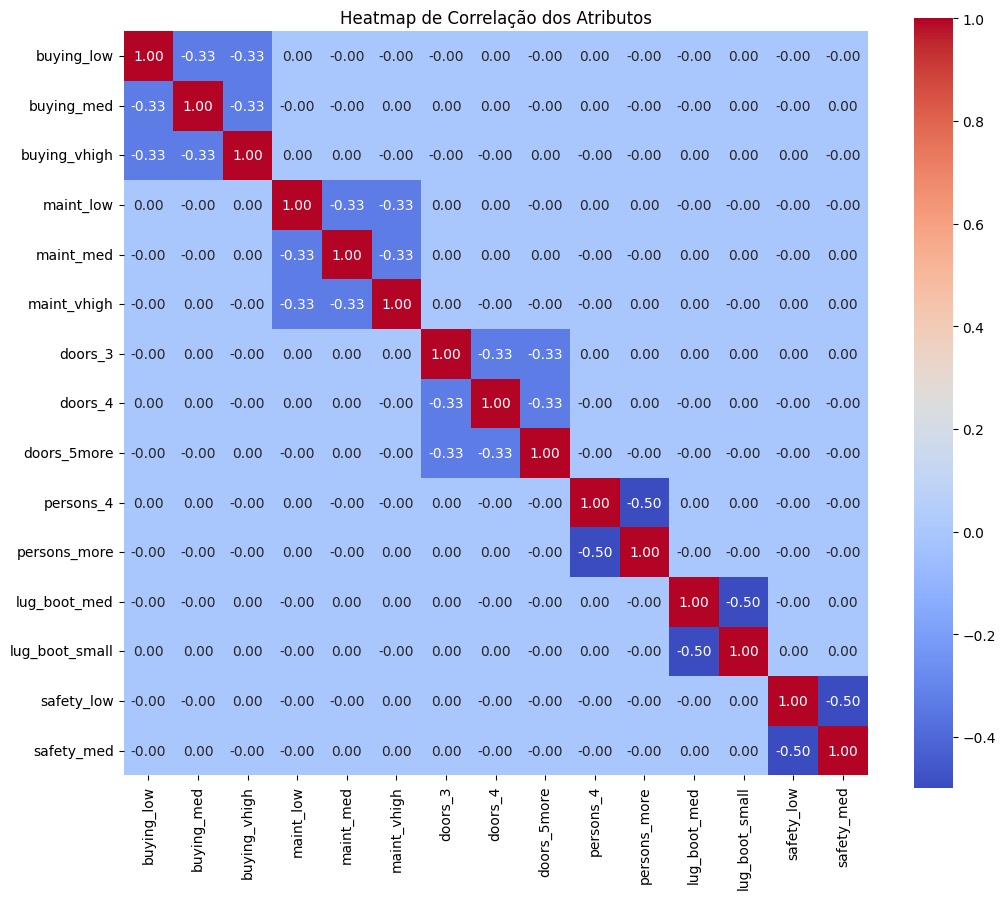

In [133]:
# Filtrando colunas numéricas e calculando a matriz de correlação
numeric_columns = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df_encoded[numeric_columns].corr()

# Criando o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title('Heatmap de Correlação dos Atributos')
plt.show()
